### <span style = 'color:blue'> TimeSeries</span>

The given data is about Footfaals and we have 158 rows and here we have foot falls from 1709 to 2132 
here we have time interval as months
predict the data using any forecasting method for next 10 footfalls values


In [1]:
# Importing libraries
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import itertools
from itertools import product

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# loading the dataset
df = pd.read_csv('footfalls.csv')

In [3]:
# lets review the dataset
df

,Month,Footfalls,t,log_footfalls,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Jan-91,1709,1,7.443664,1,1,0,0,0,0,0,0,0,0,0,0,0
1,Feb-91,1621,2,7.390799,4,0,1,0,0,0,0,0,0,0,0,0,0
2,Mar-91,1973,3,7.587311,9,0,0,1,0,0,0,0,0,0,0,0,0
3,Apr-91,1812,4,7.502186,16,0,0,0,1,0,0,0,0,0,0,0,0
4,May-91,1975,5,7.588324,25,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Nov-03,2076,155,7.638198,24025,0,0,0,0,0,0,0,0,0,0,1,0
155,Dec-03,2141,156,7.669028,24336,0,0,0,0,0,0,0,0,0,0,0,1
156,Jan-04,1832,157,7.513164,24649,1,0,0,0,0,0,0,0,0,0,0,0
157,Feb-04,1838,158,7.516433,24964,0,1,0,0,0,0,0,0,0,0,0,0


- In the Dataset there are 17 columns and 159 rows.
- Out of 17 columns many, we are focused on performing univariate time series analysis so, we only need footfall and log_footfalls rest all are not important for us


In [4]:
# let's see the datatype of every features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Month          159 non-null    object 
 1   Footfalls      159 non-null    int64  
 2   t              159 non-null    int64  
 3   log_footfalls  159 non-null    float64
 4   t_square       159 non-null    int64  
 5   Jan            159 non-null    int64  
 6   Feb            159 non-null    int64  
 7   Mar            159 non-null    int64  
 8   Apr            159 non-null    int64  
 9   May            159 non-null    int64  
 10  Jun            159 non-null    int64  
 11  Jul            159 non-null    int64  
 12  Aug            159 non-null    int64  
 13  Sep            159 non-null    int64  
 14  Oct            159 non-null    int64  
 15  Nov            159 non-null    int64  
 16  Dec            159 non-null    int64  
dtypes: float64(1), int64(15), object(1)
memory usage: 21.2

- We found that datatype of Month is object, which we need to change to  datetime so that we can perform timeseries on the same and remove the unwanted columns

In [5]:
# for timeseries analysis make a copy of original dataset 
ts = df.copy()

In [6]:
# changing the datatype of month from object to datetime as per the format
ts['Month'] = pd.to_datetime(ts['Month'], format='%b-%y',dayfirst=True)

In [7]:
# removing the unwanted columns and keeping only footfalls and month
ts=ts.drop(columns=['t','t_square','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','log_footfalls'])

In [8]:
ts

,Month,Footfalls
0,1991-01-01,1709
1,1991-02-01,1621
2,1991-03-01,1973
3,1991-04-01,1812
4,1991-05-01,1975
...,...,...
154,2003-11-01,2076
155,2003-12-01,2141
156,2004-01-01,1832
157,2004-02-01,1838


In [9]:
# reviewing the datatype of cols
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      159 non-null    datetime64[ns]
 1   Footfalls  159 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


In [10]:
# for time series we need to change index to datetime col means set month as index..
ts.set_index('Month',inplace=True)

In [11]:
ts

,Footfalls
Month,
1991-01-01,1709
1991-02-01,1621
1991-03-01,1973
1991-04-01,1812
1991-05-01,1975
...,...
2003-11-01,2076
2003-12-01,2141
2004-01-01,1832


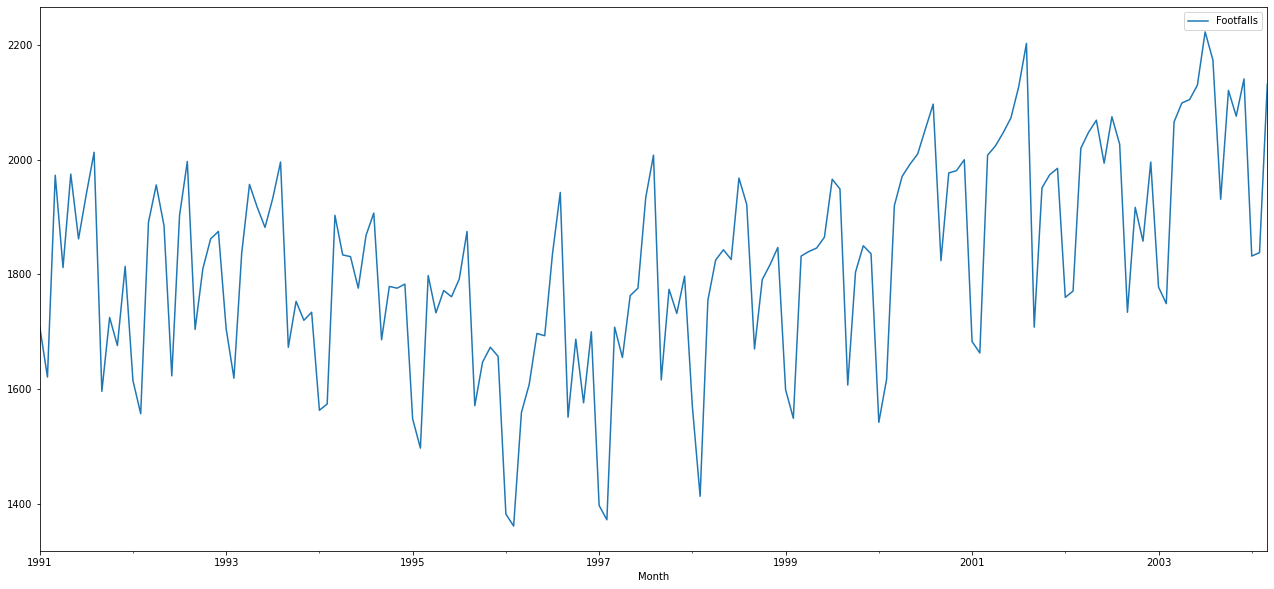

In [12]:
# plot the footfalls of every year to review the dataset
ts.plot(figsize=(22,10));

- from the above plot we can clearly say that there is some sort of Trend and seasonality in Data.
- Which clearly tells us that data is non stationary

# Train Test Split

- Before proceeding further lets divide the data into Train and Test
- Where in from start date to 70% length of data will be in training and rest of it would in testing

In [13]:
# Split the dataset in train and test of 70/30 ratio.
train = ts[:int(0.7*(len(ts)))]
test = ts[int(0.7*(len(ts))):]

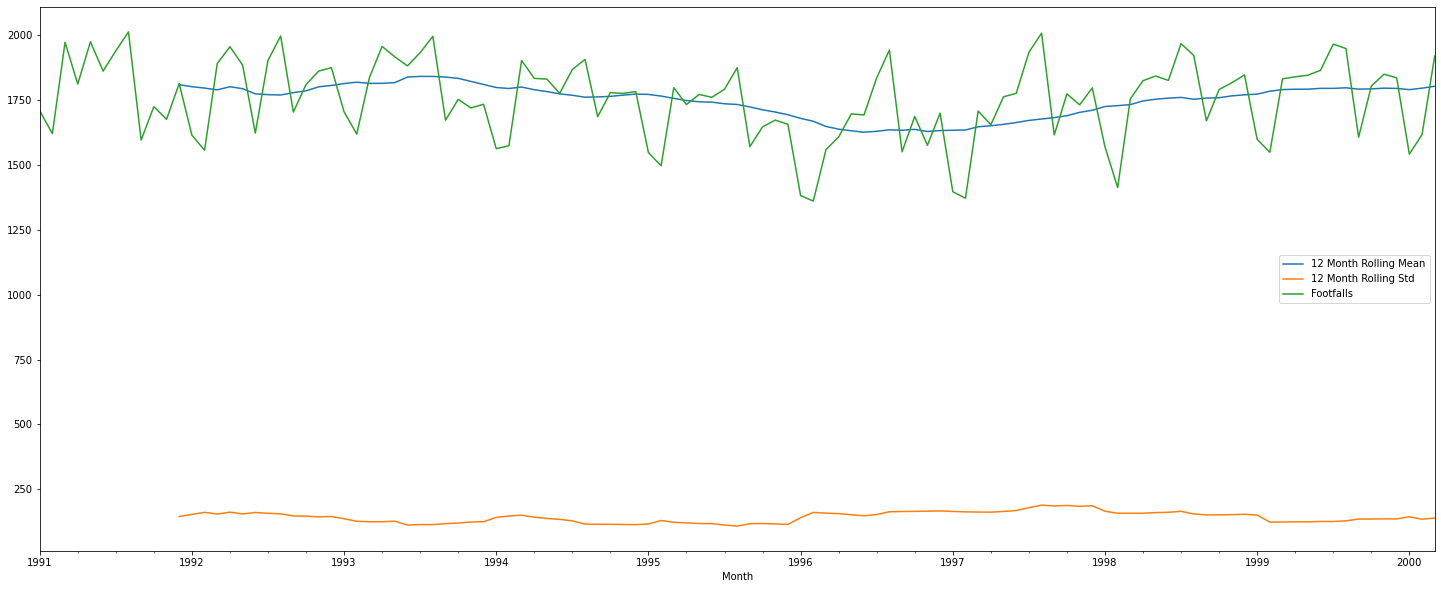

In [14]:
# Now clearly visualise the kind of trend and various components lets plot the rolling meand and std deviation 
# along with footfall so that we can see the variation the trends properly and think about the processes to detrend the data
plt.figure(figsize=(25,10))
timeseries = train['Footfalls']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend();

<Figure size 432x288 with 0 Axes>

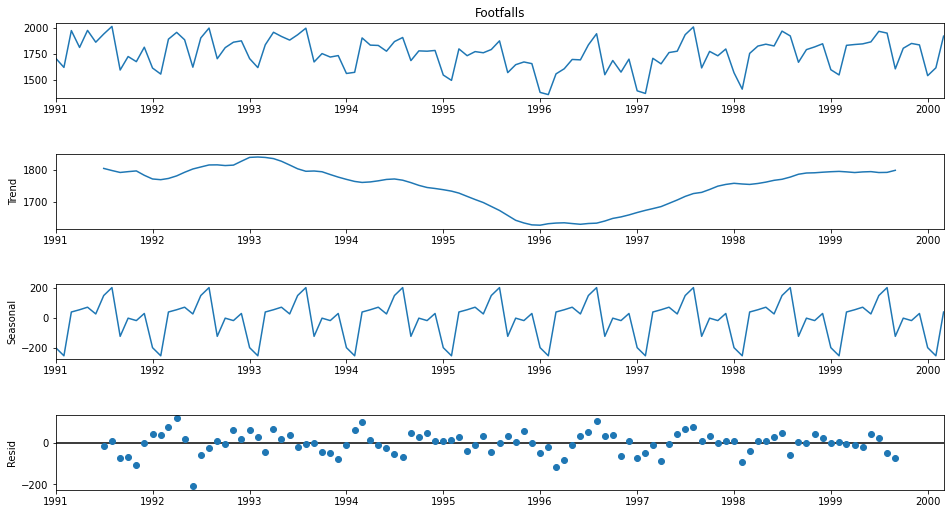

In [15]:
# seasonal_decompose is inbuilt command to decompose the data in to trend, seasonality and residuals so visualise the data
decomposition = seasonal_decompose(train['Footfalls'], period=12);  
figure = plt.figure();  
figure = decomposition.plot();
figure.set_size_inches(15, 8);

- From the above graphs we can clearly see that there is definiely a seasonality in data of 12 months as, after every 12 months we can visualise similar pattern.

- Till year 1996 there in downward trend in the data after which there is upward trend.


In [16]:
# Now as we have understood the trend and seasonality in the data, we need to statistically determine the stationarity in data
# For that lets define a function using ADF test
# in that we will use pvalue and compare with alpha of 0.05 to determine stationarity.

def check_adf(time_series):
    test_result = adfuller(time_series)
    print ('ADF Test:')
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
        print (label+ ':'+str(value))
    if test_result [1] <= 0.05:
        print ("Reject null hypothesis and data is stationary")
    else:
        print ("fail to reject H0 and data is non-stationary ")

In [17]:
# Let's check the stationarity of footfalls
check_adf(train['Footfalls'])

ADF Test:
ADF Statistic:-1.06847484385577
p-value:0.7274786897402201
No. of Lags Used:12
Number of Observations Used:98
fail to reject H0 and data is non-stationary 


- Here we can clearly see that pvalue is more than 0.05 so data is non stationary which was clearly visible from the plots also.

- Now to make the stationary we need to remove the trend and seasonality from the dataset using differencing and seasonal differencing.

In [18]:
# Firstly we will detrend the data using difference of lag(1) and then will check for stationarity.
train['Footfalls_first_diff'] = train['Footfalls'] - train['Footfalls'].shift(1)
check_adf(train['Footfalls_first_diff'].dropna())

ADF Test:
ADF Statistic:-4.5042824426547785
p-value:0.00019316583174760636
No. of Lags Used:11
Number of Observations Used:98
Reject null hypothesis and data is stationary


- Here by we got the results as stationary after first differencing

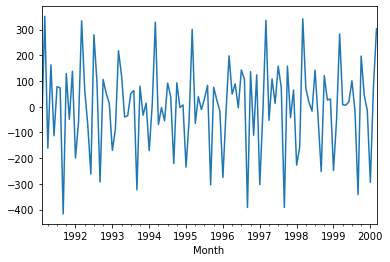

In [19]:
# Let's plot the first_diff data to see the changes occured
train['Footfalls_first_diff'].dropna().plot();

- Here we can clearly see that Trend in data has been removed but there is still presence of seasonality in it, which we can remove by using seasonal differencing.


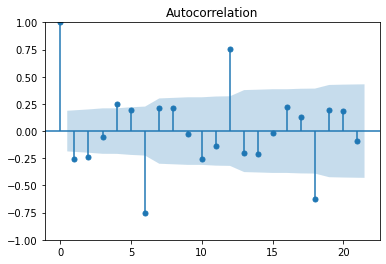

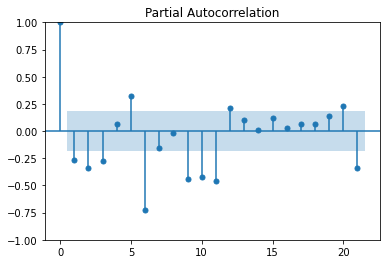

In [20]:
# lets plot acf and pacf for Footfalls_first_diff
plot_acf(train['Footfalls_first_diff'].dropna());
plot_pacf(train['Footfalls_first_diff'].dropna());

- seasonality is visible in acf and pacf plots which we have used to determine the order of AR and MA models

In [21]:
# As we got that above result is still having seasonality, we can remove those by differencing of 12 shift.
# as after every 12 months there is siilar pattern in plot.
train['Footfalls_seasonal_diff'] = train['Footfalls_first_diff'] - train['Footfalls_first_diff'].shift(12)
check_adf(train['Footfalls_seasonal_diff'].dropna())

ADF Test:
ADF Statistic:-3.370239069812265
p-value:0.012016237639351923
No. of Lags Used:11
Number of Observations Used:86
Reject null hypothesis and data is stationary


- Yeah, we got the result as stationary!!


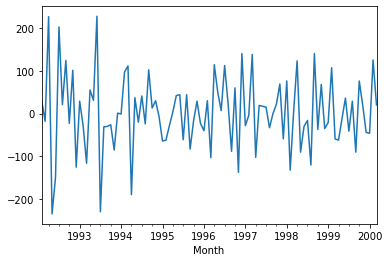

In [22]:
# seasonal difference plot
train['Footfalls_seasonal_diff'].dropna().plot();

Now that the data are stationary, let us proceed to the next step in the process – the ACF and PACF plots.

ACF and PACF Plots

By now, we have been able to identify 3 out of 7 components for our SARIMA equation. Those are trend differencing order(d), seasonal differencing order(D) and lag = 12. Let us now try and figure out the other 4 components, i.e – p and seasonal P, q and seasonal Q. In order to figure these out, we would need to plot the ACF and PACF plots.

ACF stands for Auto Correlation Function and PACF stands for Partial Auto Correlation Function.



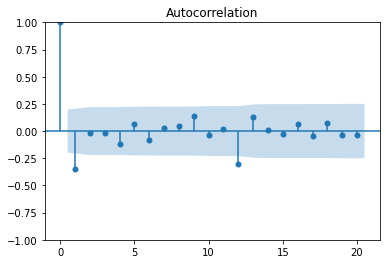

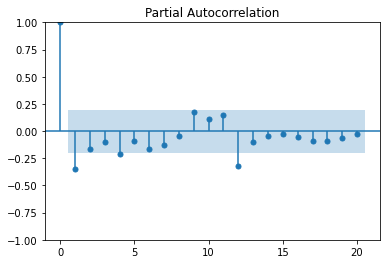

In [23]:
# lets plot acf and pacf for Footfalls_seasonal_diff
plot_acf(train['Footfalls_seasonal_diff'].dropna());
plot_pacf(train['Footfalls_seasonal_diff'].dropna());

We can see that –

- For ACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 12, which means a probable AR order of 1 and seasonal AR order of 1
- For PACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 12, which means a probable MA order of 1 or 2 and seasonal MA order of 1

So, our probable SARIMA model equation can be –

SARIMA(1,1,1)x(1,1,1)12

### Model Creation

Since we are unsure of the exact model equation, we will perform a grid search with the list of possible values around our estimated parameters. We will then pick the model with the least AIC.

In [24]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [25]:
# Determing p,d,q combinations with AIC scores.
ans = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(ts['Footfalls'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(maxiter=50)
            ans.append([param,param_seasonal,results.aic])
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue
            
        # Find parameter with minimal AIC value
        # for that we need to convert and to dataframe
        
    ans_df = pd.DataFrame(ans,columns=['pdq','seasonal_pdq','aic'])
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2824.5346515512365
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2437.3271585624684
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1758.1617759931296
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1609.209523337687
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1766.1651451988823
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1751.9361314535429
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1620.6677628158923
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1602.0007223722916
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2612.4598951308335
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2247.9141357980516
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1697.4810655888646
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1540.758280275764
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1771.8134449390623
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1687.5163151063605
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1564.3706029567406
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1544.3747885813088
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2057.898873016234
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - 

In [26]:
ans_df

,pdq,seasonal_pdq,aic
27,"(0, 1, 1)","(0, 1, 1, 12)",1444.555449
59,"(1, 1, 1)","(0, 1, 1, 12)",1445.703500
31,"(0, 1, 1)","(1, 1, 1, 12)",1446.406889
63,"(1, 1, 1)","(1, 1, 1, 12)",1447.502523
43,"(1, 0, 1)","(0, 1, 1, 12)",1459.519621
...,...,...,...
32,"(1, 0, 0)","(0, 0, 0, 12)",2072.127915
9,"(0, 0, 1)","(0, 0, 1, 12)",2247.914136
1,"(0, 0, 0)","(0, 0, 1, 12)",2437.327159
8,"(0, 0, 1)","(0, 0, 0, 12)",2612.459895


In [27]:
#SARIMA(1, 1, 1)x(1, 1, 1, 12)

mod = sm.tsa.statespace.SARIMAX(ts['Footfalls'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12))
results = mod.fit(method = 'powell')
print(results.summary())

Optimization terminated successfully.
         Current function value: 5.094991
         Iterations: 4
         Function evaluations: 237
                                     SARIMAX Results                                      
Dep. Variable:                          Footfalls   No. Observations:                  159
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -810.104
Date:                            Wed, 12 Oct 2022   AIC                           1630.207
Time:                                    12:53:03   BIC                           1645.125
Sample:                                01-01-1991   HQIC                          1636.269
                                     - 03-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

Residual Check

Once we have a fitted model to the data, it is necessary to check the residual plots to verify the validity of the model fit. A good forecasting method will yield residuals with the following properties:

- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals that should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals are noramlly distributed. if the residuals are not normally distributed, it would suggest that assumptions made by the modeling process were perhaps incorrect and that a different modeling method may be required.A large skew may suggest the opportunity for performing a transform to the data prior to modeling, such as taking the log or square root.

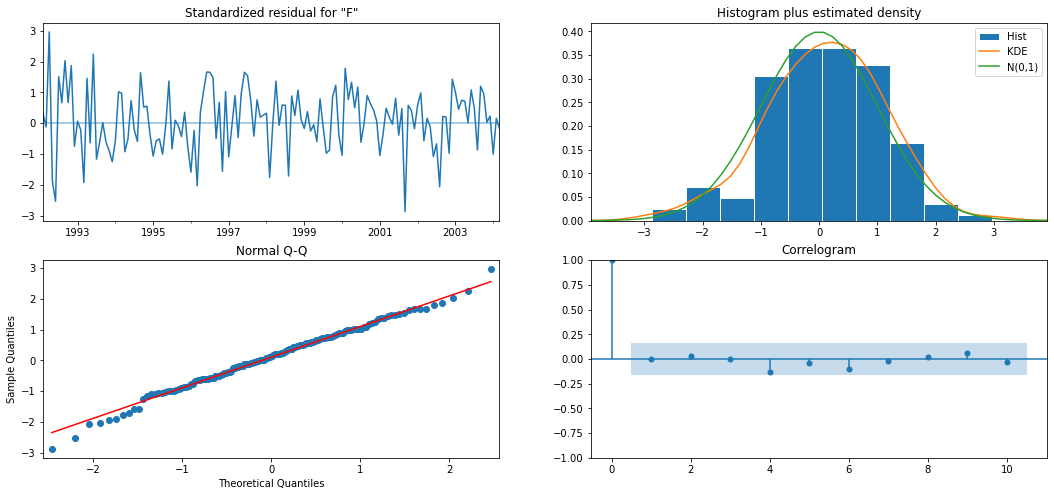

In [28]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [29]:
# Now that we have prepared the model it's time to predict the data and check the accuracy
# lets check the first month fof test dataset so that we can use that in prediction
test.head(1)

,Footfalls
Month,
2000-04-01,1971


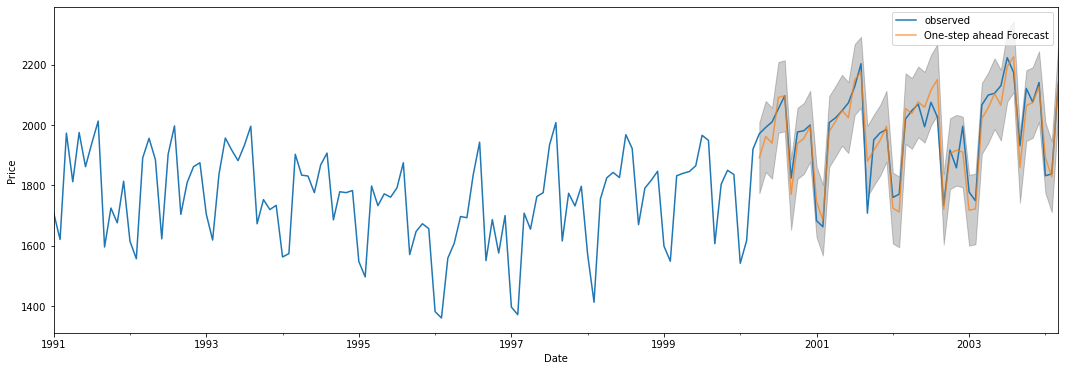

In [30]:
# Here by will predict the data for the test data and plot the actual and predicted values along with the confidence interval
# so that we could know the variation in the prediction.


# Get forecast starting from test dataset.
pred = results.get_prediction(start=pd.to_datetime('2000-04-01'), dynamic=False)

# # Get confidence intervals of forecasts
pred_ci = pred.conf_int()
ax = ts['Footfalls'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

- from above graph we can clearly say that predicted data has given fairly good result as its all time near to the actual value.


- also, grey shaded area determines the confidence intervals of the predicted values which, it continuously increasing as time is increasing, which tells us that Time Series is good predictor for shorter future prediction.

In [31]:
# Now that we have got the predicted values it's time to determine the error.
# For that we will calculate mean squared error and root mean squared error.

y_forecasted = pred.predicted_mean
y_truth = ts['Footfalls']['2000-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2613.39
The Root Mean Squared Error is 51.12


# Conclusion

- Here by we got RMSE as 51.12 which is fairly a good value. 

- Also footfalls are fairly seasonal thing and since the year 1997 are in the upwars trends

- worst year was 1996 during which footfalls were very less and since than footfalls are continuously increasing.

- Middle months of every year are having highest no of footfalls while start and end of every year have least footfalls.